## Setup

In [1]:
import pandas as pd
import geopandas as gpd
import requests
from io import StringIO

import boto3
import duckdb


import matplotlib.pyplot as plt

import numpy as np
import s2sphere
from botocore.config import Config
from rasterstats import zonal_stats


from shapely.geometry import box


# Time just the query execution

USE_CRS = "EPSG:5349"

In [2]:
response = requests.get(
    "https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson"
)
renabap = gpd.read_file(StringIO(response.text))
renabap_pba = renabap[renabap["provincia"] == "Buenos Aires"]
renabap_pba = renabap_pba.to_crs(USE_CRS)

In [3]:
peligro_path = "/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_datos_originales.geojson"
peligro = gpd.read_file(peligro_path)
peligro = peligro.to_crs(USE_CRS)

In [4]:
# Get the bounds of the peligro layer
peligro_bounds = peligro.total_bounds
print(f"Peligro layer bounds: {peligro_bounds}")

# Create a bounding box geometry from the peligro bounds
peligro_bbox = box(*peligro_bounds)

# Filter renabap_pba to only include geometries that intersect with the peligro bounds
renabap_pba_intersect = renabap_pba[
    renabap_pba.geometry.intersects(peligro_bbox)
].copy()

print(f"Original renabap_pba count: {len(renabap_pba)}")
print(f"After filtering to peligro bounds: {len(renabap_pba_intersect)}")

# make sure all geometries are valid
renabap_pba_intersect = renabap_pba_intersect[renabap_pba_intersect.geometry.is_valid]

print(f"After buffer and validation: {len(renabap_pba_intersect)}")

Peligro layer bounds: [7098513.70402481 6080729.35905791 7158548.17810223 6139974.26979945]
Original renabap_pba count: 2065
After filtering to peligro bounds: 323
After buffer and validation: 323


## Areal Interpolation, Unweighted

In [52]:
import geopandas as gpd
from tobler.area_weighted import area_interpolate

# Ensure both GeoDataFrames have the same CRS
if renabap_pba_intersect.crs != peligro.crs:
    peligro = peligro.to_crs(renabap_pba_intersect.crs)

# Get unique hazard levels
hazard_levels = peligro["PELIGROSID"].unique()

# Initialize output columns in renabap_pba_intersect
for level in hazard_levels:
    renabap_pba_intersect[f"porcion_{level}"] = 0.0

# For each hazard level, calculate the portion of each barrio that falls within it
for level in hazard_levels:
    # Filter hazard polygons for this level
    hazard_subset = peligro[peligro["PELIGROSID"] == level].copy()

    if not hazard_subset.empty:
        # Add dummy variable with value 1 for each hazard polygon
        hazard_subset["hazard_area"] = 1

        # Interpolate hazard area to barrios (this gives us the proportion)
        results = area_interpolate(
            source_df=hazard_subset,
            target_df=renabap_pba_intersect,
            extensive_variables=["hazard_area"],
        )

        # This gives us the portion of each barrio that overlaps with this hazard level
        renabap_pba_intersect[f"porcion_{level}"] = results["hazard_area"]

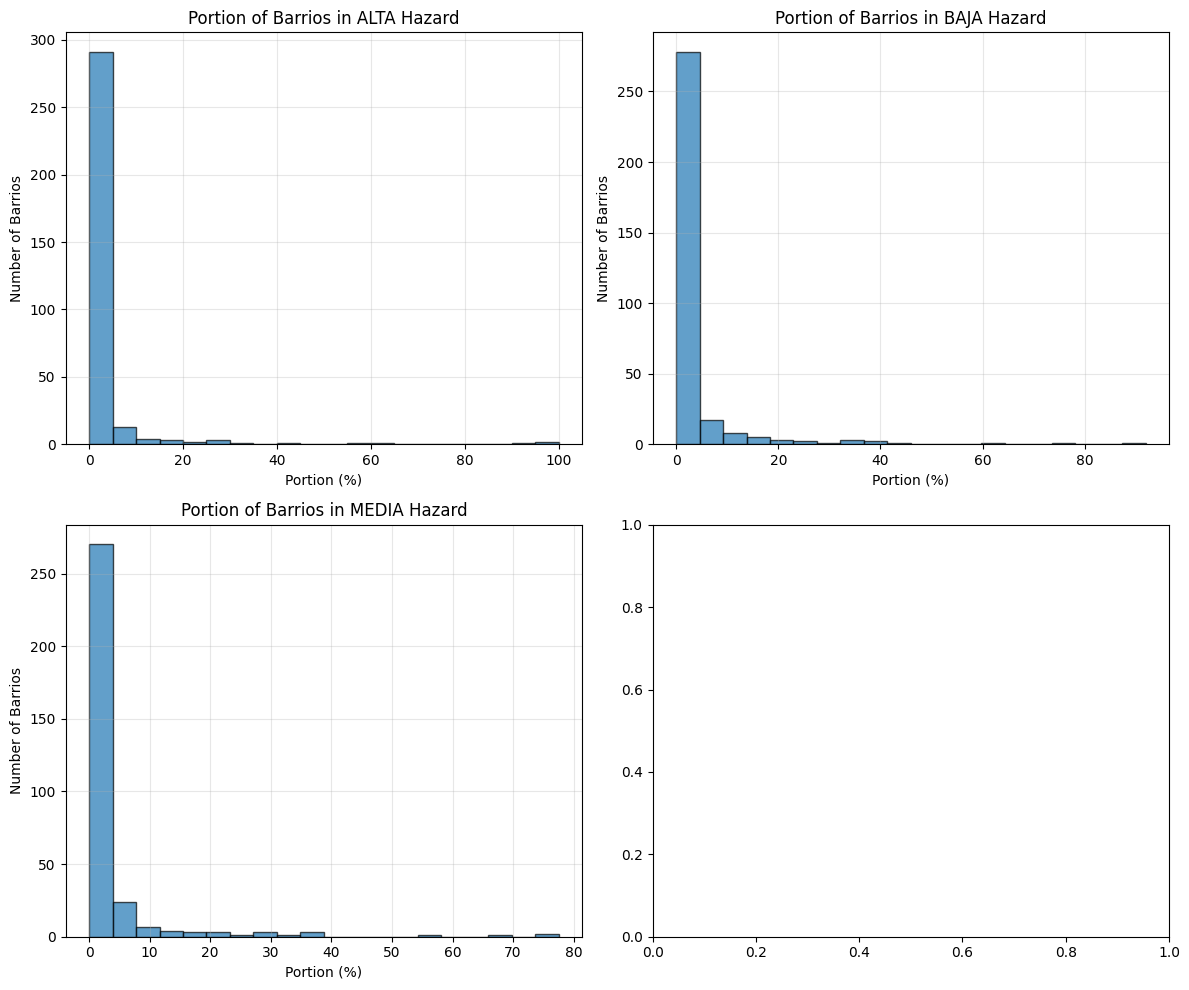

ALTA: Mean=2.8%, Max=100.0%, Barrios with >0%: 91
BAJA: Mean=3.1%, Max=91.9%, Barrios with >0%: 167
MEDIA: Mean=3.1%, Max=77.5%, Barrios with >0%: 145


In [6]:
# Create a single figure with subplots for each hazard level
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each hazard level
for i, level in enumerate(hazard_levels):
    data = renabap_pba_intersect[f"porcion_{level}"] * 100  # Convert to percentage
    axes[i].hist(data, bins=20, alpha=0.7, edgecolor="black")
    axes[i].set_title(f"Portion of Barrios in {level.upper()} Hazard")
    axes[i].set_xlabel("Portion (%)")
    axes[i].set_ylabel("Number of Barrios")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
for level in hazard_levels:
    data = renabap_pba_intersect[f"porcion_{level}"] * 100
    print(
        f"{level.upper()}: Mean={data.mean():.1f}%, Max={data.max():.1f}%, Barrios with >0%: {(data > 0).sum()}"
    )

In [7]:
# Calculate families exposed to each hazard level
for level in hazard_levels:
    renabap_pba_intersect[f"familias_expuestas_{level}"] = (
        renabap_pba_intersect[f"porcion_{level}"]
        * renabap_pba_intersect["familias_aproximadas"]
    )

# Summary
total_familias = renabap_pba_intersect["familias_aproximadas"].sum()
print(f"Total families in dataset: {total_familias:.0f}")

for level in hazard_levels:
    total_exposed = renabap_pba_intersect[f"familias_expuestas_{level}"].sum()
    print(f"Total families exposed to {level} hazard: {total_exposed:.0f}")

Total families in dataset: 88856
Total families exposed to alta hazard: 2694
Total families exposed to baja hazard: 3786
Total families exposed to media hazard: 4345


In [37]:
print(renabap_pba_intersect.head())

   id_renabap nombre_barrio     provincia departamento            localidad  \
1           2   Malvinas II  Buenos Aires     La Plata  José Melchor Romero   
2           3   Ferroviario  Buenos Aires     La Plata     Angel Etcheverry   
3           4   La Favelita  Buenos Aires     La Plata               Tolosa   
4           5        Casaca  Buenos Aires     La Plata            City Bell   
5           6     La Güemes  Buenos Aires     La Plata     Manuel B. Gonnet   

   familias_aproximadas                                           geometry  \
1                   319  MULTIPOLYGON (((7133413.584 6125858.719, 71336...   
2                   146  MULTIPOLYGON (((7127613.216 6115863.573, 71276...   
3                   134  MULTIPOLYGON (((7136174.621 6130304.579, 71361...   
4                    22  MULTIPOLYGON (((7128546.05 6130775.49, 7128519...   
5                    13  MULTIPOLYGON (((7129976.453 6132330.669, 71299...   

   porcion_alta  porcion_baja  porcion_media  familias_e

In [57]:
# Create tidy dataframe with the three required columns
renabap_tidy = renabap_pba_intersect[["nombre_barrio"]].copy()

# Calculate total familias_expuestas
renabap_tidy["fam_expuestas_areal"] = (
    renabap_pba_intersect["familias_expuestas_alta"]
    + renabap_pba_intersect["familias_expuestas_baja"]
    + renabap_pba_intersect["familias_expuestas_media"]
)

# Determine highest hazard level (peligrosidad)
def get_highest_hazard(row):
    exposures = [
        row["familias_expuestas_alta"],
        row["familias_expuestas_baja"],
        row["familias_expuestas_media"],
    ]
    hazard_levels = ["alta", "baja", "media"]
    return hazard_levels[exposures.index(max(exposures))]

renabap_tidy["peligrosidad"] = renabap_pba_intersect.apply(get_highest_hazard, axis=1)

# Round fam_expuestas_areal
renabap_tidy["fam_expuestas_areal"] = renabap_tidy["fam_expuestas_areal"].round(2)

print(renabap_tidy.head())

  nombre_barrio  fam_expuestas_areal peligrosidad
1   Malvinas II                 0.06         baja
2   Ferroviario                14.15         baja
3   La Favelita                 3.46        media
4        Casaca                 2.79         alta
5     La Güemes                 0.28         alta


## Areal Interpolation, GHSL Weighting

In [8]:
import rioxarray
from shapely.geometry import box

# Load GHSL data with dask chunking for memory efficiency
ghsl = rioxarray.open_rasterio(
    "/home/nissim/Downloads/spatial/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif",
    chunks={"x": 1024, "y": 1024},  # Adjust chunk size based on your memory constraints
)

# Reproject to your target CRS with streaming
ghsl = ghsl.rio.reproject(dst_crs=USE_CRS)

# Clip to renabap_pba_intersect bounding box using streaming
bounding_box = box(
    *renabap_pba_intersect.total_bounds
)  # Create a box from the bounding box coordinates

ghsl_clipped = ghsl.rio.clip(
    [bounding_box],  # Use the bounding box as a geometry (wrapped in a list)
    from_disk=True,  # Process from disk to avoid loading entire dataset into memory
)


# If you need to compute the result (only when you actually need the data)
# ghsl_final = ghsl_clipped.compute()

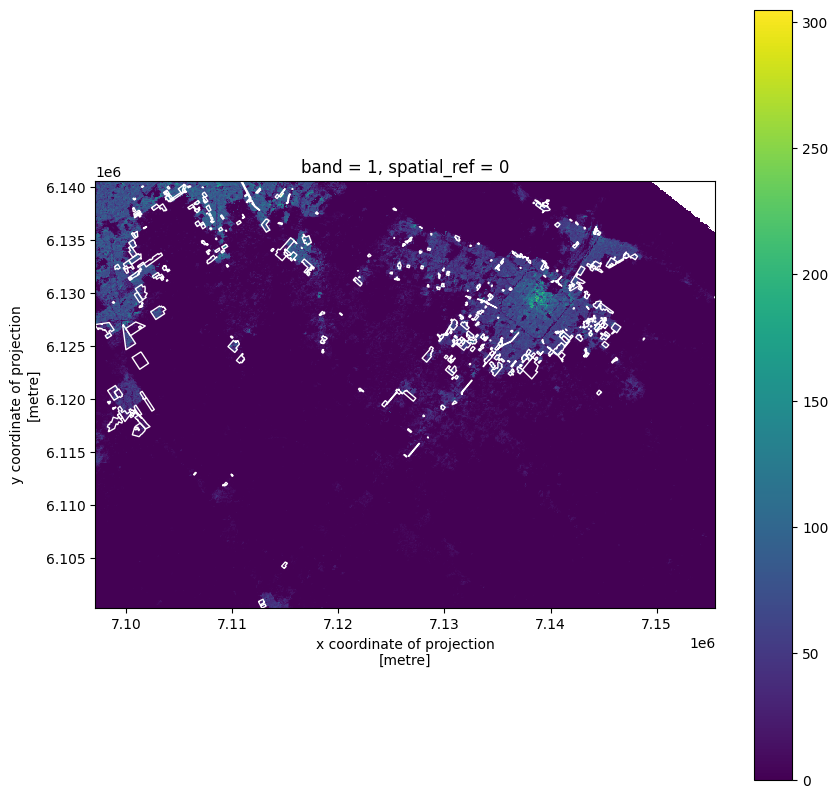

In [11]:
import matplotlib.pyplot as plt

# Create a plot with the desired size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GHSL clipped data on the ax, excluding values below 0
ghsl_clipped_positive = ghsl_clipped.where(ghsl_clipped >= 0)
ghsl_clipped_positive.plot(ax=ax, cmap="viridis")

# Plot the RENABAP polygons on top of the raster
renabap_pba_intersect.plot(ax=ax, edgecolor="white", facecolor="none")

# Show the plot
plt.show()

In [12]:
import rasterstats

# Step 1: Calculate the total GHSL population per barrio popular using zonal statistics
print("Calculating GHSL population totals per barrio popular...")

# Convert to the format expected by rasterstats
geometries = [geom for geom in renabap_pba_intersect.geometry]

# Use rasterstats for vectorized zonal statistics
stats = rasterstats.zonal_stats(
    geometries,
    ghsl_clipped.values[0],  # rasterstats expects 2D array
    affine=ghsl_clipped.rio.transform(),
    stats=["sum"],
    nodata=ghsl_clipped.rio.nodata,
)

# Extract the sum values
ghsl_totals = [stat["sum"] if stat["sum"] is not None else 0 for stat in stats]

# Add the GHSL population estimates as a new column
renabap_pba_intersect["ghsl_pop_est"] = ghsl_totals

# Verify the results
print(f"Added GHSL population estimates to {len(ghsl_totals)} barrios")
print(f"Total estimated population: {sum(ghsl_totals):,.0f}")
print(f"Range: {min(ghsl_totals):.0f} - {max(ghsl_totals):.0f}")

# Show a few examples
print("\nFirst 5 barrios with GHSL estimates:")
print(renabap_pba_intersect[["geometry", "ghsl_pop_est"]].head())

Calculating GHSL population totals per barrio popular...
Added GHSL population estimates to 323 barrios
Total estimated population: 257,167
Range: 0 - 9332

First 5 barrios with GHSL estimates:
                                            geometry  ghsl_pop_est
1  MULTIPOLYGON (((7133413.584 6125858.719, 71336...    729.961555
2  MULTIPOLYGON (((7127613.216 6115863.573, 71276...    240.369900
3  MULTIPOLYGON (((7136174.621 6130304.579, 71361...    265.001049
4  MULTIPOLYGON (((7128546.05 6130775.49, 7128519...     10.639407
5  MULTIPOLYGON (((7129976.453 6132330.669, 71299...      0.000000


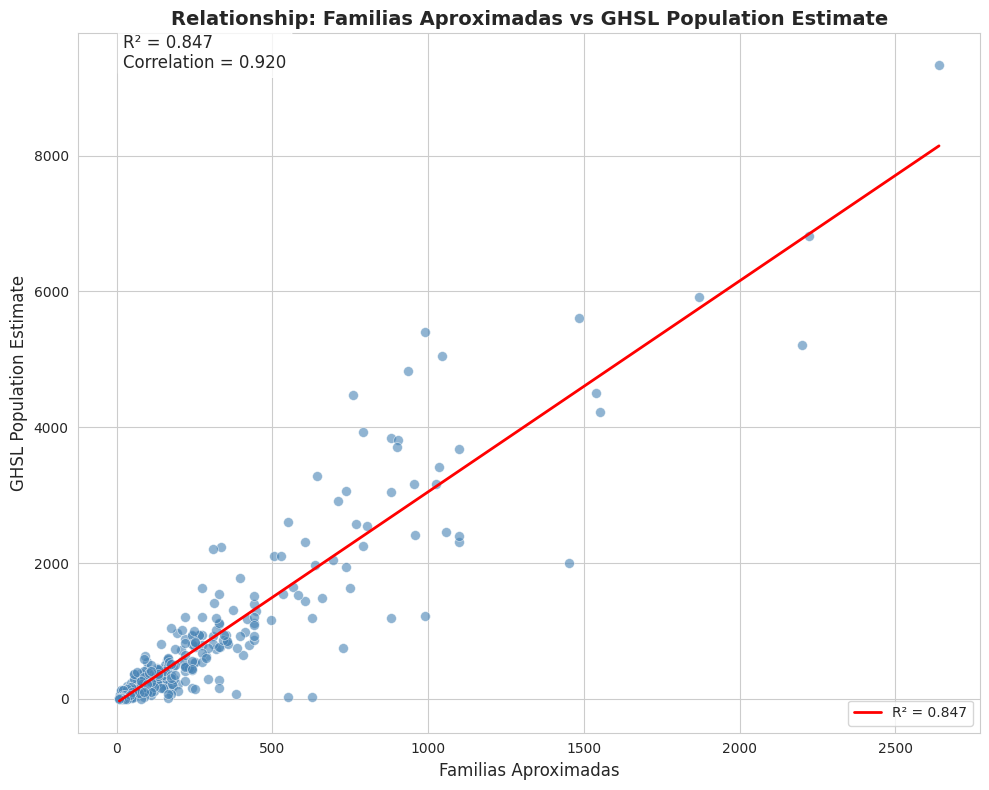

Number of observations: 323
R-squared: 0.847
Correlation coefficient: 0.920
P-value: 7.084e-133
Slope: 3.107
Intercept: -58.472


In [13]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Filter out any NaN values for the analysis
valid_data = renabap_pba_intersect.dropna(
    subset=["familias_aproximadas", "ghsl_pop_est"]
)

# Calculate correlation and R-squared
correlation, p_value = stats.pearsonr(
    valid_data["familias_aproximadas"], valid_data["ghsl_pop_est"]
)
r_squared = correlation**2

# Calculate line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(
    valid_data["familias_aproximadas"], valid_data["ghsl_pop_est"]
)

# Create the plot
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Scatter plot
plt.scatter(
    valid_data["familias_aproximadas"],
    valid_data["ghsl_pop_est"],
    alpha=0.6,
    s=50,
    color="steelblue",
    edgecolors="white",
    linewidth=0.5,
)

# Line of best fit
x_range = np.linspace(
    valid_data["familias_aproximadas"].min(),
    valid_data["familias_aproximadas"].max(),
    100,
)
y_fit = slope * x_range + intercept
plt.plot(x_range, y_fit, color="red", linewidth=2, label=f"R² = {r_squared:.3f}")

# Add labels and title
plt.xlabel("Familias Aproximadas", fontsize=12)
plt.ylabel("GHSL Population Estimate", fontsize=12)
plt.title(
    "Relationship: Familias Aproximadas vs GHSL Population Estimate",
    fontsize=14,
    fontweight="bold",
)

# Add R-squared text
plt.text(
    0.05,
    0.95,
    f"R² = {r_squared:.3f}\nCorrelation = {correlation:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of observations: {len(valid_data)}")
print(f"R-squared: {r_squared:.3f}")
print(f"Correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3e}")
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")

In [15]:
from rasterio.features import rasterize
import numpy as np

# Get the reference raster properties from GHSL data
reference_raster = ghsl_clipped
reference_transform = reference_raster.rio.transform()
reference_crs = reference_raster.rio.crs
reference_shape = reference_raster.shape[1:]  # Get 2D shape (height, width)

print(f"Reference raster shape: {reference_shape}")
print(f"Reference CRS: {reference_crs}")

# Prepare geometries and values for rasterization
geometries_ghsl = [
    (geom, value)
    for geom, value in zip(
        renabap_pba_intersect.geometry, renabap_pba_intersect["ghsl_pop_est"]
    )
]
geometries_familias = [
    (geom, value)
    for geom, value in zip(
        renabap_pba_intersect.geometry, renabap_pba_intersect["familias_aproximadas"]
    )
]

Reference raster shape: (490, 711)
Reference CRS: EPSG:5349


In [16]:
# Create GHSL population raster
ghsl_pop_raster = rasterize(
    geometries_ghsl,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=False,
)

# Create familias aproximadas raster
familias_raster = rasterize(
    geometries_familias,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=False,
)

# Verify the rasters
print(
    f"GHSL population range: {np.nanmin(ghsl_pop_raster):.2f} - {np.nanmax(ghsl_pop_raster):.2f}"
)
print(
    f"Familias range: {np.nanmin(familias_raster):.2f} - {np.nanmax(familias_raster):.2f}"
)

GHSL population range: 0.00 - 9332.04
Familias range: 0.00 - 2640.00


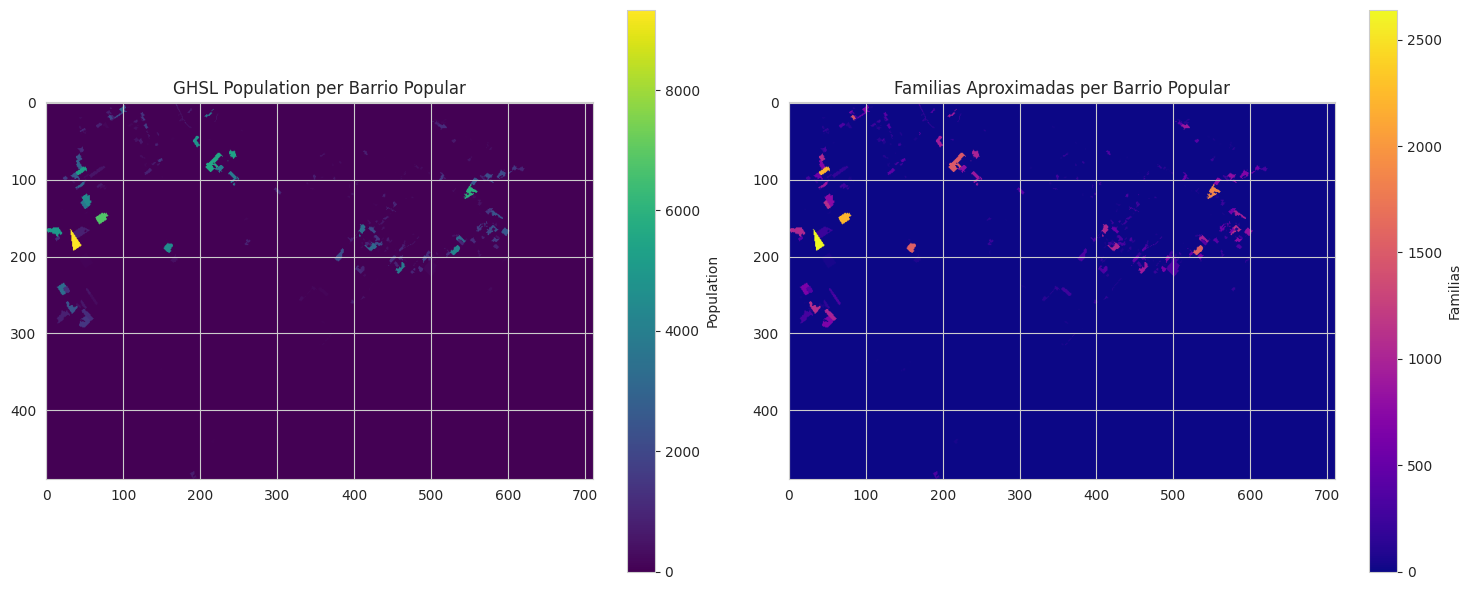

In [17]:
# Optional: Create a quick visualization to verify
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot GHSL population raster
im1 = ax1.imshow(ghsl_pop_raster, cmap="viridis")
ax1.set_title("GHSL Population per Barrio Popular")
plt.colorbar(im1, ax=ax1, label="Population")

# Plot familias raster
im2 = ax2.imshow(familias_raster, cmap="plasma")
ax2.set_title("Familias Aproximadas per Barrio Popular")
plt.colorbar(im2, ax=ax2, label="Familias")

plt.tight_layout()
plt.show()

Original GHSL range: -200.00 - 304.95
Fractional population range: -200.0000 - 1.0000
Downscaled familias range: -200.00 - 383.00

Total original familias: 88,856
Total downscaled familias: 88,680
Difference: 176.00


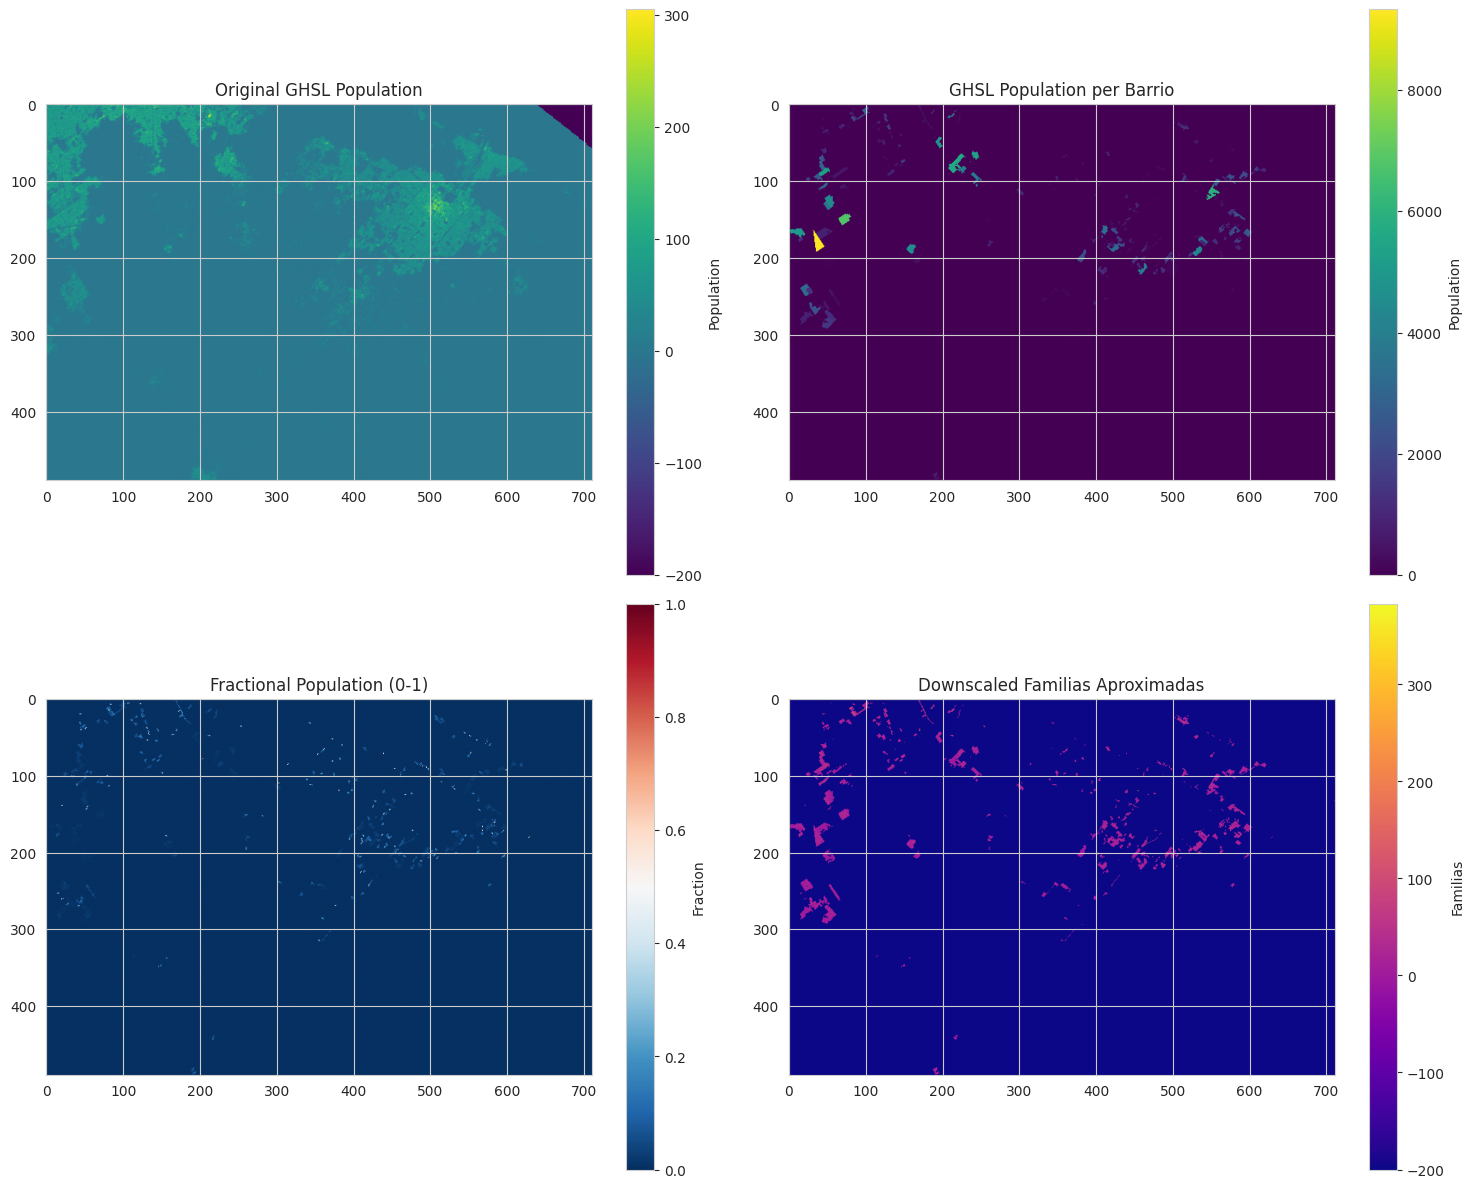

In [18]:
# Step 1: Divide original GHSL by the barrio-level GHSL to get fractional population
# Handle division by zero and nodata values properly
mask = (ghsl_clipped.values[0] > 0) & (ghsl_pop_raster > 0.1)
ghsl_fractional = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
ghsl_fractional[mask] = ghsl_clipped.values[0][mask] / ghsl_pop_raster[mask]

# Step 2: Multiply fractional population by familias aproximadas to get downscaled data
mask2 = (ghsl_fractional > 0) & (familias_raster > 0)
familias_downscaled = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
familias_downscaled[mask2] = ghsl_fractional[mask2] * familias_raster[mask2]

# Verify the results
print(
    f"Original GHSL range: {np.nanmin(ghsl_clipped.values[0]):.2f} - {np.nanmax(ghsl_clipped.values[0]):.2f}"
)
print(
    f"Fractional population range: {np.nanmin(ghsl_fractional):.4f} - {np.nanmax(ghsl_fractional):.4f}"
)
print(
    f"Downscaled familias range: {np.nanmin(familias_downscaled):.2f} - {np.nanmax(familias_downscaled):.2f}"
)

# Check that the sum of downscaled familias equals the original familias aproximadas
total_original_familias = renabap_pba_intersect["familias_aproximadas"].sum()
valid_downscaled = familias_downscaled[familias_downscaled != -200]
total_downscaled_familias = np.sum(valid_downscaled)
print(f"\nTotal original familias: {total_original_familias:,.0f}")
print(f"Total downscaled familias: {total_downscaled_familias:,.0f}")
print(f"Difference: {abs(total_original_familias - total_downscaled_familias):,.2f}")

# Optional: Create visualization to verify the downscaling
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Original GHSL
im1 = ax1.imshow(ghsl_clipped.values[0], cmap="viridis")
ax1.set_title("Original GHSL Population")
plt.colorbar(im1, ax=ax1, label="Population")

# Barrio-level GHSL
im2 = ax2.imshow(ghsl_pop_raster, cmap="viridis")
ax2.set_title("GHSL Population per Barrio")
plt.colorbar(im2, ax=ax2, label="Population")

# Fractional population
im3 = ax3.imshow(ghsl_fractional, cmap="RdBu_r", vmin=0, vmax=1)
ax3.set_title("Fractional Population (0-1)")
plt.colorbar(im3, ax=ax3, label="Fraction")

# Downscaled familias
im4 = ax4.imshow(familias_downscaled, cmap="plasma")
ax4.set_title("Downscaled Familias Aproximadas")
plt.colorbar(im4, ax=ax4, label="Familias")

plt.tight_layout()
plt.show()

In [19]:
# Step 1: Divide original GHSL by the barrio-level GHSL to get fractional population
# Use masking to avoid division on invalid cells
mask = (ghsl_clipped.values[0] != -200) & (ghsl_pop_raster > 0.1)
ghsl_fractional = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
ghsl_fractional[mask] = ghsl_clipped.values[0][mask] / ghsl_pop_raster[mask]

# Step 2: Multiply fractional population by familias aproximadas to get downscaled data
mask2 = (ghsl_fractional != -200) & (familias_raster > 0)
familias_downscaled = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
familias_downscaled[mask2] = ghsl_fractional[mask2] * familias_raster[mask2]

# Verify the results - exclude -200 from range calculations
ghsl_valid = ghsl_clipped.values[0] != -200
fractional_valid = ghsl_fractional != -200
downscaled_valid = familias_downscaled != -200

print(
    f"Original GHSL range: {np.min(ghsl_clipped.values[0][ghsl_valid]):.2f} - {np.max(ghsl_clipped.values[0][ghsl_valid]):.2f}"
)
print(
    f"Fractional population range: {np.min(ghsl_fractional[fractional_valid]):.4f} - {np.max(ghsl_fractional[fractional_valid]):.4f}"
)
print(
    f"Downscaled familias range: {np.min(familias_downscaled[downscaled_valid]):.2f} - {np.max(familias_downscaled[downscaled_valid]):.2f}"
)

# Check that the sum of downscaled familias equals the original familias aproximadas
total_original_familias = renabap_pba_intersect["familias_aproximadas"].sum()
total_downscaled_familias = np.sum(familias_downscaled[downscaled_valid])
print(f"\nTotal original familias: {total_original_familias:,.0f}")
print(f"Total downscaled familias: {total_downscaled_familias:,.0f}")
print(f"Difference: {abs(total_original_familias - total_downscaled_familias):,.2f}")

Original GHSL range: 0.00 - 304.95
Fractional population range: 0.0000 - 1.0000
Downscaled familias range: 0.00 - 383.00

Total original familias: 88,856
Total downscaled familias: 88,680
Difference: 176.00


In [20]:
# Intersect settlements with hazard zones
settlement_hazard = gpd.overlay(renabap_pba_intersect, peligro, how="intersection")

In [40]:
# Create GHSL tidy dataframe with matching structure
ghsl_tidy = []

for idx, row in settlement_hazard.iterrows():
    stats = zonal_stats(
        [row.geometry],
        familias_downscaled,  # your numpy array
        affine=reference_transform,  # get transform from your xarray
        stats=["sum"],
        nodata=-200,  # use your actual nodata value
    )[0]

    ghsl_tidy.append(
        {
            "nombre_barrio": row["nombre_barrio"],
            "peligrosidad": row["PELIGROSID"],
            "fam_expuestas_ghsl": stats["sum"] if stats["sum"] is not None else 0,
        }
    )

ghsl_tidy = pd.DataFrame(ghsl_tidy)

print(ghsl_tidy.head())

  nombre_barrio peligrosidad  fam_expuestas_ghsl
0   Malvinas II         baja            0.000000
1   Ferroviario         baja           14.286419
2   Ferroviario        media           32.931858
3   La Favelita         alta            0.000000
4   La Favelita        media          134.000006


In [54]:
ghsl_tidy["fam_expuestas_ghsl"].isna().sum()

np.int64(0)

## Areal Interpolation, Building Foootprints Weighting

In [32]:
def fetch_buildings(geodataframe, temp_file="buildings_filtered.parquet"):
    """Fetch building data for a given GeoDataFrame region"""

    # Get S2 cell and bounds
    center = geodataframe.to_crs("epsg:3857").union_all().centroid
    center_wgs84 = (
        gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857")
        .to_crs(epsg=4326)
        .geometry.iloc[0]
    )
    cell = s2sphere.CellId.from_lat_lng(
        s2sphere.LatLng.from_degrees(center_wgs84.y, center_wgs84.x)
    ).parent(10)
    bounds = geodataframe.to_crs("epsg:4326").total_bounds

    # Find matching S2 partition
    s3 = boto3.client(
        "s3",
        endpoint_url="https://data.source.coop",
        aws_access_key_id="",
        aws_secret_access_key="",
        config=Config(s3={"addressing_style": "path"}),
    )

    partitions = {
        obj["Key"].split("/")[-1].replace(".parquet", "")
        for obj in s3.list_objects_v2(
            Bucket="vida",
            Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
        ).get("Contents", [])
    }

    parent_id = next(
        str(cell.parent(level).id())
        for level in range(10, 0, -1)
        if str(cell.parent(level).id()) in partitions
    )

    # Setup DuckDB and query
    con = duckdb.connect()
    for cmd in [
        "INSTALL spatial",
        "LOAD spatial",
        "INSTALL httpfs",
        "LOAD httpfs",
        "SET s3_region='us-east-1'",
        "SET s3_endpoint='data.source.coop'",
        "SET s3_use_ssl=true",
        "SET s3_url_style='path'",
    ]:
        con.execute(cmd)

    # Export and read back
    query = f"""
    COPY (SELECT * FROM 's3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet'
          WHERE bbox.xmax >= {bounds[0]} AND bbox.xmin <= {bounds[2]} AND
                bbox.ymax >= {bounds[1]} AND bbox.ymin <= {bounds[3]}
    ) TO '{temp_file}' (FORMAT PARQUET);
    """

    con.execute(query)
    df = pd.read_parquet(temp_file)
    df["geometry"] = gpd.GeoSeries.from_wkb(df["geometry"])

    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")


# Usage:
buildings = fetch_buildings(renabap_pba_intersect)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [41]:
# Reproject buildings to match the analysis CRS
buildings_proj = buildings.to_crs(USE_CRS)

# Step 1: Calculate buildings per settlement-hazard intersection
buildings_hazard = gpd.overlay(buildings_proj, settlement_hazard, how="intersection")

# Count buildings per settlement-hazard combination
buildings_per_hazard = (
    buildings_hazard.groupby(["nombre_barrio", "PELIGROSID"])
    .size()
    .reset_index(name="buildings_count")
)

# Step 2: Calculate total buildings per settlement (barrio popular)
buildings_settlement = gpd.overlay(
    buildings_proj, renabap_pba_intersect, how="intersection"
)
total_buildings_per_settlement = (
    buildings_settlement.groupby("nombre_barrio")
    .size()
    .reset_index(name="total_buildings")
)

# Step 3: Merge and calculate ratios
hazard_ratios = buildings_per_hazard.merge(
    total_buildings_per_settlement, on="nombre_barrio", how="left"
)
hazard_ratios["building_ratio"] = (
    hazard_ratios["buildings_count"] / hazard_ratios["total_buildings"]
)

# Step 4: Get total population per settlement and apply ratios
settlement_population = renabap_pba_intersect[
    ["nombre_barrio", "familias_aproximadas"]
].copy()

# Merge with ratios and calculate population estimates
population_estimates = hazard_ratios.merge(
    settlement_population, on="nombre_barrio", how="left"
)
population_estimates["estimated_population_hazard"] = (
    population_estimates["building_ratio"]
    * population_estimates["familias_aproximadas"]
)

# Step 5: Create final results with totals
final_results = population_estimates[
    ["nombre_barrio", "PELIGROSID", "estimated_population_hazard"]
].copy()

# Add total population rows (no hazard breakdown)
total_pop_rows = settlement_population.copy()
total_pop_rows["PELIGROSID"] = "total"
total_pop_rows["estimated_population_hazard"] = total_pop_rows["familias_aproximadas"]

# Combine
final_results = pd.concat(
    [
        final_results,
        total_pop_rows[["nombre_barrio", "PELIGROSID", "estimated_population_hazard"]],
    ],
    ignore_index=True,
)

# Create buildings tidy dataframe with matching structure
buildings_tidy = final_results[
    ["nombre_barrio", "PELIGROSID", "estimated_population_hazard"]
].copy()

# Rename columns to match the structure
buildings_tidy = buildings_tidy.rename(
    columns={
        "PELIGROSID": "peligrosidad",
        "estimated_population_hazard": "fam_expuestas_edificios",
    }
)

# Filter out the 'total' rows since we only want hazard-specific data
buildings_tidy = buildings_tidy[buildings_tidy["peligrosidad"] != "total"].copy()

print(buildings_tidy.head())

  nombre_barrio peligrosidad  fam_expuestas_edificios
0      116 y 77         alta                 3.735849
1      116 y 77         baja                15.566038
2      116 y 77        media                 6.226415
3     154 y 413         baja                 2.040816
4      155 y 46         alta                20.806452


In [55]:
buildings_tidy["fam_expuestas_edificios"].isna().sum()

np.int64(0)

In [ ]:
buildings.plot()

## Results

In [62]:
# Join all three dataframes by nombre_barrio and peligrosidad
final_df = renabap_tidy.merge(
    ghsl_tidy, on=["nombre_barrio", "peligrosidad"], how="outer"
)
final_df = final_df.merge(
    buildings_tidy, on=["nombre_barrio", "peligrosidad"], how="outer"
)

# Impute 0s for NA values in fam_expuestas columns
fam_expuestas_columns = [col for col in final_df.columns if 'fam_expuestas' in col]
final_df[fam_expuestas_columns] = final_df[fam_expuestas_columns].fillna(0)

In [69]:
# Create long format dataframe with aggregation
final_tidy = []

# Add renabap data
for _, row in renabap_tidy.iterrows():
    final_tidy.append(
        {
            "nombre_barrio": row["nombre_barrio"],
            "peligrosidad": row["peligrosidad"],
            "metodo": "area",
            "fam_expuestas": row["fam_expuestas_areal"],
        }
    )

# Add ghsl data
for _, row in ghsl_tidy.iterrows():
    final_tidy.append(
        {
            "nombre_barrio": row["nombre_barrio"],
            "peligrosidad": row["peligrosidad"],
            "metodo": "ghsl",
            "fam_expuestas": row["fam_expuestas_ghsl"],
        }
    )

# Add buildings data
for _, row in buildings_tidy.iterrows():
    final_tidy.append(
        {
            "nombre_barrio": row["nombre_barrio"],
            "peligrosidad": row["peligrosidad"],
            "metodo": "edificios",
            "fam_expuestas": row["fam_expuestas_edificios"],
        }
    )

final_tidy = pd.DataFrame(final_tidy)

# Aggregate to get one observation per barrio per hazard level per method
final_tidy = (
    final_tidy.groupby(["nombre_barrio", "peligrosidad", "metodo"])["fam_expuestas"]
    .sum()
    .reset_index()
)

# Create complete combination of all barrios, hazard levels, and methods
all_barrios = final_tidy["nombre_barrio"].unique()
all_hazard_levels = ["alta", "baja", "media"]
all_methods = ["area", "ghsl", "edificios"]

complete_combinations = pd.DataFrame([
    {"nombre_barrio": barrio, "peligrosidad": hazard, "metodo": method}
    for barrio in all_barrios
    for hazard in all_hazard_levels
    for method in all_methods
])

# Merge with actual data and fill missing values with 0
final_tidy = complete_combinations.merge(
    final_tidy, on=["nombre_barrio", "peligrosidad", "metodo"], how="left"
)
final_tidy["fam_expuestas"] = final_tidy["fam_expuestas"].fillna(0)

print(final_tidy.head(10))
print(f"Shape: {final_tidy.shape}")

  nombre_barrio peligrosidad     metodo  fam_expuestas
0      116 y 77         alta       area       0.000000
1      116 y 77         alta       ghsl       0.000000
2      116 y 77         alta  edificios       3.735849
3      116 y 77         baja       area       8.000000
4      116 y 77         baja       ghsl      33.000000
5      116 y 77         baja  edificios      15.566038
6      116 y 77        media       area       0.000000
7      116 y 77        media       ghsl       0.000000
8      116 y 77        media  edificios       6.226415
9   1418 y 1435         alta       area       0.000000
Shape: (2439, 4)


In [74]:
# Calculate total exposure per hazard level per method
summary = (
    final_tidy.groupby(["peligrosidad", "metodo"])["fam_expuestas"]
    .sum()
    .reset_index()
    .pivot(index="peligrosidad", columns="metodo", values="fam_expuestas")
)

print("Total Familias Expuestas por Peligrosidad y Método:")
print("=" * 50)
print(summary.round(2))

Total Familias Expuestas por Peligrosidad y Método:
metodo           area  edificios     ghsl
peligrosidad                             
alta          1909.76    3606.85  2831.97
baja          5315.18    9852.58  7726.58
media         3599.65    9717.37  8400.36


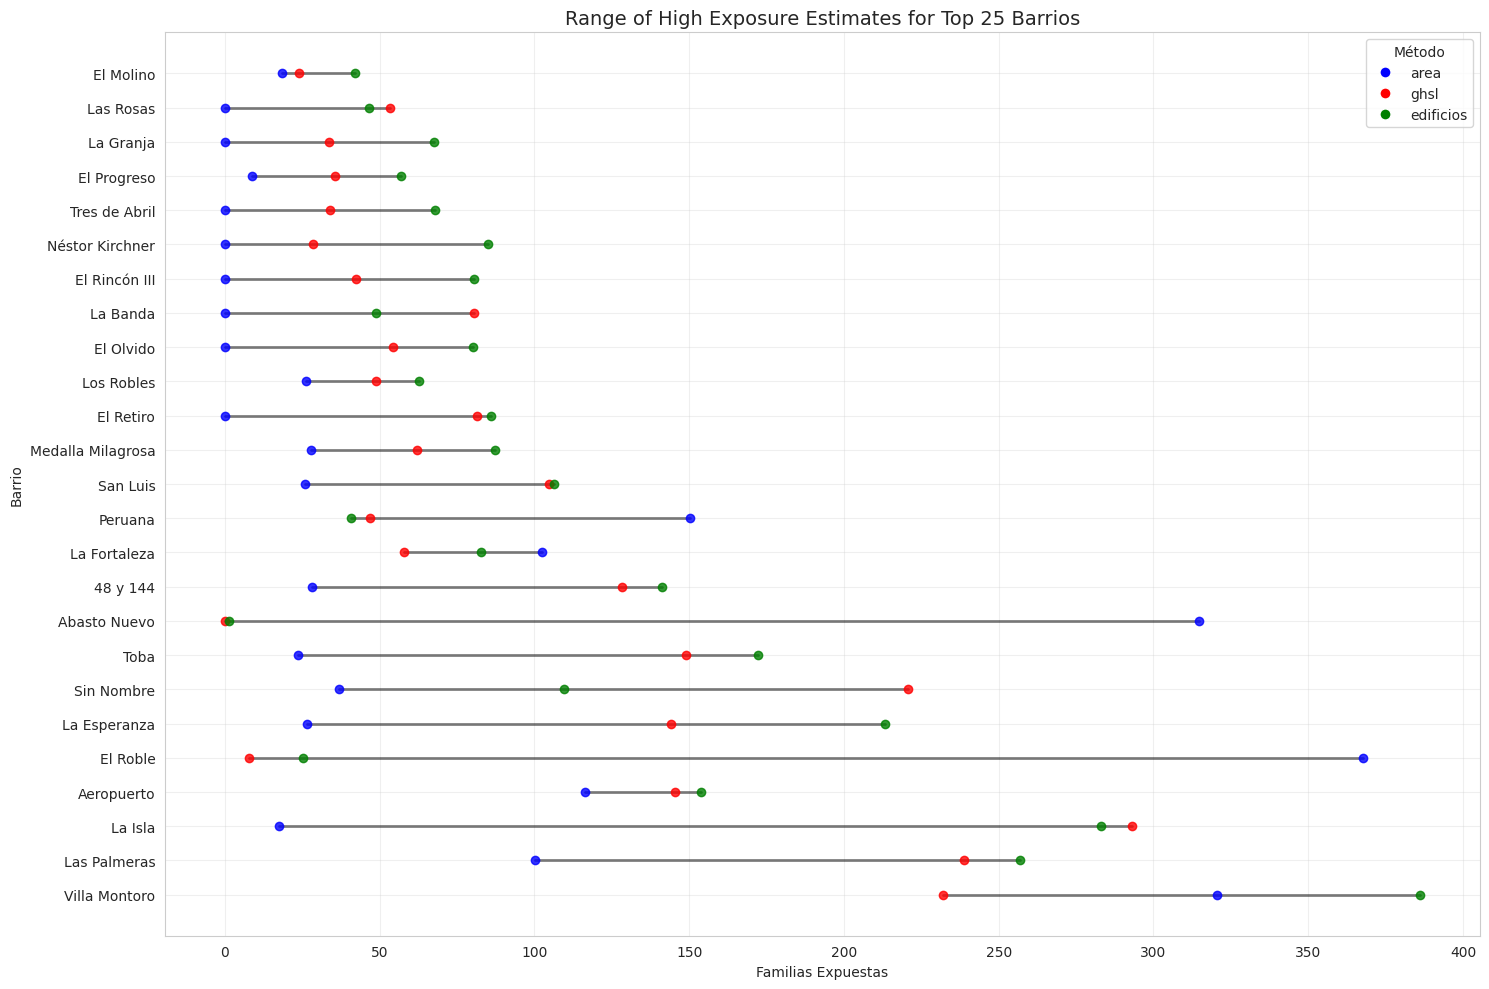

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for high exposure (alta peligrosidad)
alta_data = final_tidy[final_tidy["peligrosidad"] == "alta"].copy()

# Calculate total exposure per barrio across all methods
total_exposure = (
    alta_data.groupby("nombre_barrio")["fam_expuestas"]
    .sum()
    .sort_values(ascending=False)
)
top_25_barrios = total_exposure.head(25).index

# Filter data for top 25 barrios
top_25_data = alta_data[
    alta_data["nombre_barrio"].isin(top_25_barrios)
].copy()

# Create range plot showing min, max, and individual points
plt.figure(figsize=(15, 10))

# Define colors for methods
method_colors = {"area": "blue", "ghsl": "red", "edificios": "green"}

for i, barrio in enumerate(top_25_barrios):
    barrio_data = top_25_data[top_25_data["nombre_barrio"] == barrio]
    if len(barrio_data) > 0:
        values = barrio_data["fam_expuestas"].values
        min_val = values.min()
        max_val = values.max()

        # Plot range line
        plt.plot([min_val, max_val], [i, i], "k-", alpha=0.5, linewidth=2)

        # Plot individual points colored by method
        for _, row in barrio_data.iterrows():
            color = method_colors[row["metodo"]]
            plt.plot(row["fam_expuestas"], i, "o", color=color, markersize=6, alpha=0.8)

plt.yticks(range(len(top_25_barrios)), top_25_barrios)
plt.xlabel("Familias Expuestas")
plt.ylabel("Barrio")
plt.title("Range of High Exposure Estimates for Top 25 Barrios", fontsize=14)
plt.grid(True, alpha=0.3)

# Add legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color,
        markersize=8,
        label=method,
    )
    for method, color in method_colors.items()
]
plt.legend(handles=legend_elements, title="Método")

plt.tight_layout()
plt.show()

In [ ]:
# so we'll need to report this as a range, plus explanations of the different strengths and weaknesses of each method
# recall that, since we're working with proportions and not raw counts, the difference between downscaling with GHSL (pop) and buildings (buildings/families) will be minimal
